In [9]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from data import CleanedData
from models import nn
import sklearn.metrics
import torch
import sklearn.metrics
import matplotlib.pyplot as plt

# For Adaboost
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data imputing, cleaning and feature extraction

In [2]:
data = CleanedData(loc='./data/joined.csv.gz', test_ratio=0.2, impute_data=True, convert_non_numerical=True, normalize_data=True, drop_columns=['source', 'Last_Update','province','country','latitude', 'longitude'])

/opt/miniconda3/envs/cmpt353/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## Splitting data to test and training data

In [3]:
X_train, y_train = data.training_data
X_test, y_test = data.test_data

In [4]:
X_train.head(5)

,age,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio,confirmed_day,in_contact,transformed_Combined_Key,transformed_sex
536773,29.000000,-38.416100,-63.616700,13.342196,9.457122,13.077527,11.790996,7.228607,2.054632,126.0,0.0,26.0,1.0
94939,41.000000,-11.766533,-76.604498,12.763306,9.547455,0.000000,12.722357,8.097181,4.012120,102.0,0.0,238.0,1.0
559,39.250317,15.912900,79.740000,13.320489,8.564840,13.161374,11.343595,7.030711,0.860295,139.0,0.0,16.0,2.0
6709,40.682942,23.541513,78.289633,11.517495,7.550135,11.250937,9.980680,4.768044,1.892333,132.0,0.0,248.0,2.0
310090,39.880132,26.583423,73.847973,11.619895,7.176255,11.432420,9.782280,4.922457,1.175308,137.0,0.0,374.0,2.0


## Model 1 variations, neural network with different hyperparameters and architectures

In [42]:
models = []
trained_models = 13
for i in range(trained_models):
    models.append(nn.network_1())
    nn.load_model(models[i], f'./models/weights/model_{i}.pth')

## Accuracy of each model on training and validation data

In [43]:
for i in range(trained_models):
    print(f'training accuracy of model_{i+1}: {nn.eval(models[i], X_train, y_train):.2f}%')
    print(f'validation accuracy of model_{i+1}: {nn.eval(models[i], X_test, y_test):.2f}%')

training accuracy of model_1: 81.00%
validation accuracy of model_1: 81.13%
training accuracy of model_2: 84.39%
validation accuracy of model_2: 84.42%
training accuracy of model_3: 82.90%
validation accuracy of model_3: 82.98%
training accuracy of model_4: 82.89%
validation accuracy of model_4: 82.95%
training accuracy of model_5: 83.03%
validation accuracy of model_5: 83.11%
training accuracy of model_6: 83.11%
validation accuracy of model_6: 83.20%
training accuracy of model_7: 82.18%
validation accuracy of model_7: 82.22%
training accuracy of model_8: 84.38%
validation accuracy of model_8: 84.40%
training accuracy of model_9: 84.48%
validation accuracy of model_9: 84.51%
training accuracy of model_10: 84.81%
validation accuracy of model_10: 84.84%
training accuracy of model_11: 84.94%
validation accuracy of model_11: 84.98%
training accuracy of model_12: 84.77%
validation accuracy of model_12: 84.79%
training accuracy of model_13: 84.84%
validation accuracy of model_13: 84.89%


## Making predictions

In [44]:
models_training_preds = []
models_validation_preds = []
for i in range(trained_models):
    models_training_preds.append(torch.argmax(torch.softmax(models[i](torch.tensor(X_train.values).float()), dim=1), dim=1))
    models_validation_preds.append(torch.argmax(torch.softmax(models[i](torch.tensor(X_test.values).float()), dim=1), dim=1))

## F-2 scores of different models 

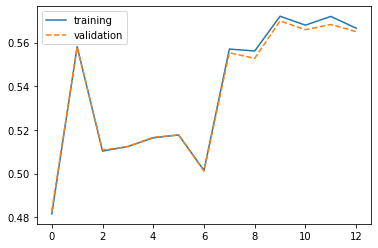

In [45]:
fscore_training = []
fscore_validation = []
for i in range(trained_models):
    fscore_training.append(sklearn.metrics.fbeta_score(y_train, models_training_preds[i], beta=2, average="macro"))
    fscore_validation.append(sklearn.metrics.fbeta_score(y_test, models_validation_preds[i], beta=2, average="macro"))

plt.plot(fscore_training,)
plt.plot(fscore_validation,linestyle='dashed')
plt.legend(['training', 'validation'])

In [46]:
sklearn.metrics.fbeta_score(y_test, models_validation_preds[i], beta=2, average=None)

array([0.07657945, 0.92067235, 0.99481155, 0.26825918])

In [47]:
data.encoder.classes_.tolist()

['deceased', 'hospitalized', 'nonhospitalized', 'recovered']

## Confusion matrices for the best performing model

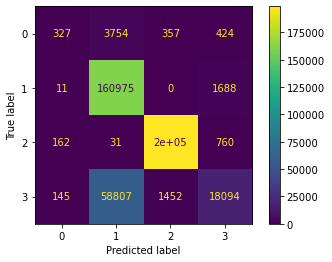

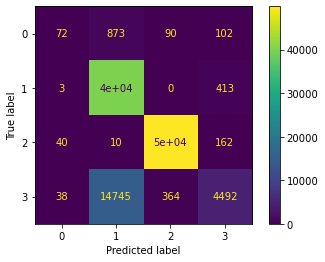

In [48]:
conf_matrix_train = sklearn.metrics.confusion_matrix(y_train.values, models_training_preds[i])
conf_matrix_val = sklearn.metrics.confusion_matrix(y_test.values, models_validation_preds[i])

sklearn.metrics.ConfusionMatrixDisplay(conf_matrix_train).plot()
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix_val).plot()

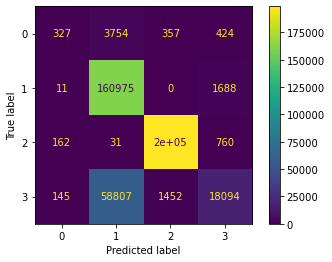

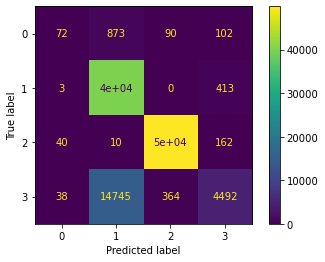

In [49]:
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix_train).plot()
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix_val).plot()

## Model 2: Adaboost

In [15]:
# adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 20),n_estimators = 25, learning_rate = 1)
# adaboost.fit(X_train, y_train)
with open('./data/adaboost_model.pkl', 'rb') as f:
    adaboost = pickle.load(f)

### Training Set Accuracy Score

In [16]:
adaboost.score(X_train,y_train)

0.8649925203923038

### Test set Accuracy Score

In [17]:
adaboost.score(X_test,y_test)

0.8662689512873419

### Confusion Matrices

#### Test Data Set

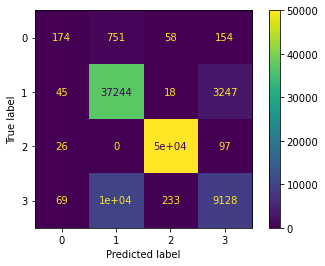

In [18]:
y_test_pred = adaboost.predict(X_test)
test_matrix = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(test_matrix).plot()

#### Training Data Set

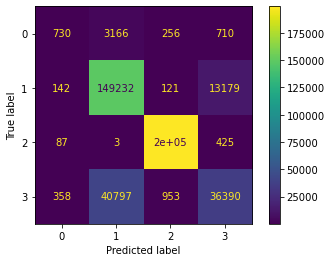

In [19]:
y_train_pred = adaboost.predict(X_train)
train_matrix = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(train_matrix).plot()

####  F-2 Scores

In [20]:
print(f'F_2 score of Adaboost on training dataset: {sklearn.metrics.fbeta_score(y_train, y_train_pred, beta=2, average="macro"):.4f}')
print(f'F_2 score of Adaboost on validation dataset: {sklearn.metrics.fbeta_score(y_test, y_test_pred, beta=2, average="macro"):.4f}')

F_2 score of Adaboost on training dataset: 0.6389
F_2 score of Adaboost on validation dataset: 0.6403


In [22]:
sklearn.metrics.fbeta_score(y_test, y_test_pred, beta=2, average=None)

array([0.17893871, 0.88499192, 0.99680731, 0.50053739])

In [23]:
import matplotlib.pyplot as plts

ranges = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45]
training_accuracy = list()
test_accuracy = list()
training_f2score = list()
test_f2score = list()

for i in ranges:
    adaboost_overfit = AdaBoostClassifier(DecisionTreeClassifier(max_depth = i),n_estimators = 25, learning_rate = 1)
    adaboost_overfit.fit(X_train,y_train) 
    training_accuracy.append(adaboost_overfit.score(X_train,y_train))
    test_accuracy.append(adaboost_overfit.score(X_test,y_test))
    y_test_predict = adaboost.predict(X_test)
    y_train_predict = adaboost.predict(X_train)
    training_f2score.append(sklearn.metrics.fbeta_score(y_train, y_train_predict, beta=2, average="macro"))
    test_f2score.append(sklearn.metrics.fbeta_score(y_test, y_test_predict, beta=2, average="macro"))

# Scores for loaded tree size n = 50 Adaboost Classifier
training_accuracy.append(adaboost.score(X_train,y_train))
test_accuracy.append(adaboost.score(X_test,y_test))
training_f2score.append(sklearn.metrics.fbeta_score(y_train, y_train_pred, beta=2, average="macro"))
test_f2score.append(sklearn.metrics.fbeta_score(y_test, y_test_pred, beta=2, average="macro"))

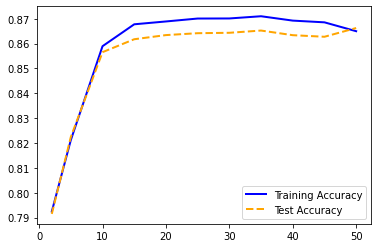

In [31]:
dict_accuracy = {'Tree_Size': ranges, 'Training_Accuracy': training_accuracy, 'Test_Accuracy': test_accuracy, 'Training_F2': training_f2score, 'Test_F2': test_f2score}  
# df = pd.DataFrame(dict_accuracy)
plts.plot( 'Tree_Size', 'Training_Accuracy', data=df, marker='', color='blue', linewidth=2, label="Training Accuracy")
plts.plot( 'Tree_Size', 'Test_Accuracy', data=df, marker='', color='orange', linewidth=2, linestyle='dashed', label="Test Accuracy")
plts.legend()

(0.635, 0.645)

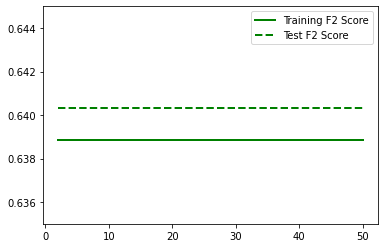

In [30]:
plts.plot( 'Tree_Size', 'Training_F2', data=df, marker='', color='green', linewidth=2, label="Training F2 Score")
plts.plot( 'Tree_Size', 'Test_F2', data=df, marker='', color='green', linewidth=2, linestyle='dashed', label="Test F2 Score")
plts.legend()
plts.ylim([0.635, 0.645])